In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
vals_1 = {
    'm1':0.5126,
    'm2':0.9998,
    'k1':230,
    'k2':72.5
}

vals_2 = { 
    'm1':0.9998, 
    'm2':0.5126, 
    'k1':230, 
    'k2':72.5
}

### Rensa datan av headers som orsakar massa problem i grafningen

In [3]:
from pathlib import Path
from sys import platform

# get all .tsv files in current directory
tsv_files = list(Path(".").glob("*.tsv"))
def clean_data(files, out_dir):  
    out_dir.mkdir(exist_ok=True)
    for file_path in files:
        out_path = out_dir / file_path.name
        print(f"Processing {file_path} → {out_path}")
    
        # read file as text and skip first 10 lines
        with file_path.open("r", encoding="utf-8") as infile:
            lines = infile.readlines()[11:]  # skip the first 10 lines
    
        # write the rest to the new file
        with out_path.open("w", encoding="utf-8") as outfile:
            outfile.writelines(lines)
clean_data(tsv_files, Path("data"))

Processing 1_f3.tsv → data/1_f3.tsv
Processing 2_f1.tsv → data/2_f1.tsv
Processing 2_f2.tsv → data/2_f2.tsv
Processing 4_f1.tsv → data/4_f1.tsv
Processing 1_f2_notgood.tsv → data/1_f2_notgood.tsv
Processing 3_f1.tsv → data/3_f1.tsv
Processing 5_f1.tsv → data/5_f1.tsv
Processing 1_f1.tsv → data/1_f1.tsv


### Läs in och bearbeta data med pandas

In [4]:
file_path = list(Path("data").glob("2_f1.tsv"))
df1 = pd.read_csv(
    file_path[0], 
    sep='\t',
    header=None,
)

df1.columns = ["x2", "y2", "z2", "x1", "y1", "z1"]
df = df1/1000

#t = np.array(range(len(df)))
t=np.arange(0.01,10,0.01)


z1_diff = (df.z1 - np.mean(df.z1))
z2_diff = (df.z2 - np.mean(df.z2))

### Numerisk lösning på systemet

In [5]:
# Define external forces f1(t), f2(t)
vals = vals_2
m1, m2, k1, k2 = vals["m1"], vals["m2"], vals["k1"], vals["k2"]

measure_nr = 0
def f1(t): 
    return 0#-9.82 * m1             # example: no forcing
def f2(t): 
    return 0#-9.82 * m2
# ODE system
def deriv(t, X):
    x1, x2, x3, x4 = X
    dx1dt = x2
    dx2dt = (f1(t) + k2*(x3 - x1) - k1*x1) / m1
    dx3dt = x4
    dx4dt = (f2(t) - k2*(x3 - x1)) / m2
    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Initial conditions
#X0 = [df.z1[measure_nr]-np.mean(df.z1), np.gradient(df.z1, t)[0], df.z2[measure_nr]-np.mean(df.z2), np.gradient(df.z2, t)[0]]
X0 = [z1_diff[0], np.gradient(df.z1, t)[0], z2_diff[0], np.gradient(df.z2, t)[0]]


print(np.gradient(df.z1, t)[0])
print(np.gradient(df.z2, t)[0])


# Time span
num_t_span = (0, 10)
num_t_eval = t #np.linspace(*num_t_span, len(t))


# Solve numerically
num_sol = solve_ivp(deriv, num_t_span, X0, t_eval=num_t_eval, rtol=1e-8, atol=1e-9)

# Extract solutions
num_t = num_sol.t
num_y1, num_y2 = num_sol.y[0], num_sol.y[2]

0.39429999999999743
0.11400000000000299


### Grafa resultat

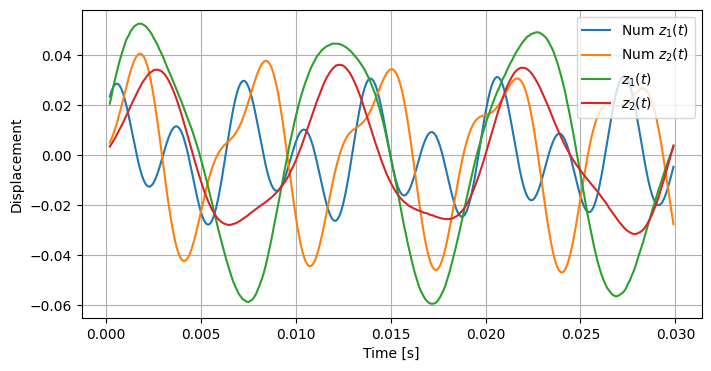

In [11]:
t_range = range(1, len(t)-700)

plt.figure(figsize=(8,4))
plt.plot(t[t_range]/100, num_y1[t_range], label='Num $z_1(t)$')
plt.plot(t[t_range]/100, num_y2[t_range], label='Num $z_2(t)$')
plt.plot(t[t_range]/100, z1_diff[t_range], label="$z_1(t)$")
plt.plot(t[t_range]/100, z2_diff[t_range], label="$z_2(t)$")
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend(loc=1)
plt.grid(True)
plt.show()

In [7]:
num_y2[0] == z2_diff[0]

np.False_

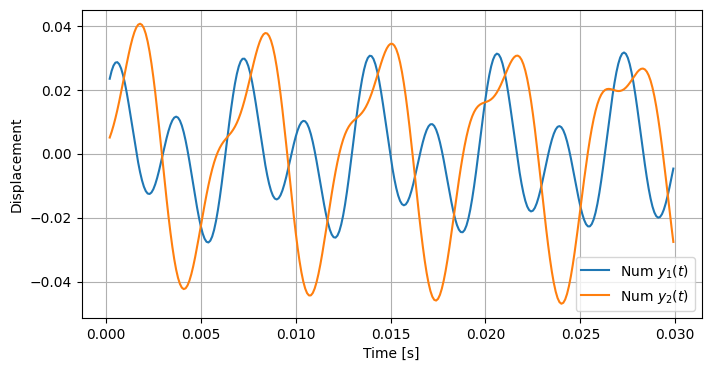

In [8]:
plt.figure(figsize=(8,4))
plt.plot(t[t_range]/100, num_y1[t_range], label='Num $y_1(t)$')
plt.plot(t[t_range]/100, num_y2[t_range], label='Num $y_2(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

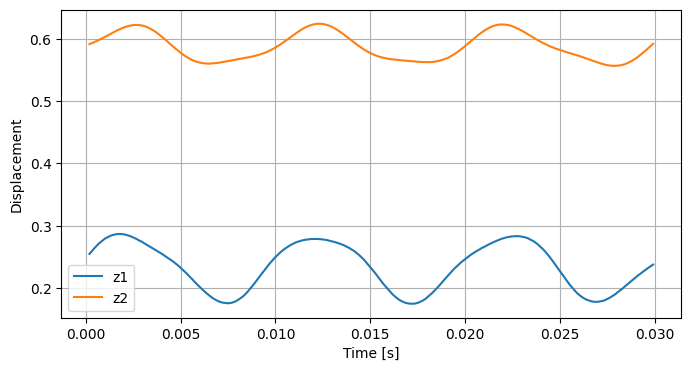

In [9]:
plt.figure(figsize=(8,4))
plt.plot(t[t_range]/100, df.z1[t_range], label="z1")
plt.plot(t[t_range]/100, df.z2[t_range], label="z2")
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
omega1 = 

SyntaxError: invalid syntax (3320195819.py, line 1)